In [1]:
import pandas as pd
#import matplotlib.pyplot as plt
import numpy as np
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
import itertools
import statsmodels.api as sm 
import matplotlib
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
selng=pd.read_csv("Z:\data\SELNG.csv", delimiter='|', engine='python')
cnfm_prmisn=pd.read_csv("Z:\data\CNFM_PRMISN.csv", delimiter='|')
rent_curprc=pd.read_csv("Z:\data\RENT_CURPRC.csv", delimiter='|')
blck_flpop=pd.read_csv("Z:\data\BLCK_FLPOP.csv", delimiter='|')
blck_dim=pd.read_csv("Z:\data\BLCK_DIM.csv", delimiter='|')
#파일 불러오기

In [3]:
cnfm_prmisn.drop(['STOR_NM','SVC_INDUTY_CD','OLD_ADRES','NW_ADRES','TELNO','PROC_CLSS','ROAD_CD','XCNTS_VALUE','YDNTS_VALUE'],axis='columns', inplace=True)
rent_curprc.drop(['STDR_QU_CD','RENT_FLOOR_CD'],axis='columns', inplace=True)
#분석할때 필요없는 데이터 정리, blck_flpop,selng 테이블은 좀 더 정리 필요

In [4]:
rent_curprc_con=(rent_curprc['CNVRSN_RNTCHRG']!=0)
#값이 '0'으로 존재하는 데이터의 경우를 제외

In [5]:
#BLCK_CD 기준으로 테이블 합쳐서 정렬(독립변수)->매출액을 기준으로(종속변수) 다중회귀분석 =>매출액 결정 요인의 분석
#시계열 분석 통해서 매출액 결정 요인/매출액 변화되는 양상 추정->예측=>K-군집분석으로 입지 유형의 분류
#입지선정

In [6]:
blck_flpop

,201701,10000,7257.11,3346.09,3911.02,1074.8,793.55,1197.91,1225.91,903.22,...,17.3,24.89.2,24,55.56,37.56.1,14.78.1,16.22.6,22,23.44,9057
0,201701,10019,18920.35,8424.45,10495.90,1612.66,4722.58,4301.48,2824.10,2032.47,...,46.37,56.25,28.92,35.38,35.84,31.81,37.23,42.35,24.58,10247
1,201701,10186,5888.34,2626.42,3261.92,949.15,604.87,580.36,1107.79,975.46,...,15.33,20.04,16.96,37.83,27.13,12.25,12.25,18.50,16.96,10786
2,201701,10499,5356.58,2416.75,2939.83,871.16,554.50,529.15,1016.78,890.83,...,12.75,16.09,14.92,34.17,25.59,11.75,10.75,15.75,15.00,10840
3,201701,10506,11518.42,5122.43,6395.99,2254.32,1091.98,1332.18,1924.88,1825.84,...,32.67,44.92,26.04,65.00,56.29,36.67,39.88,52.67,28.83,6376
4,201701,10531,5452.75,2511.50,2941.25,678.00,719.00,853.25,825.75,868.25,...,8.50,11.75,14.00,21.25,18.75,12.00,7.75,14.75,15.00,2509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201629,201912,8617,14104.22,6761.93,7342.29,1241.65,2230.73,2470.72,2322.59,2397.25,...,24.29,32.79,33.54,76.09,54.29,23.29,20.59,28.88,33.96,4760
201630,201912,9375,21742.18,10077.26,11664.92,1865.81,3840.49,5191.31,4598.50,2877.74,...,30.37,42.44,33.35,61.41,53.28,29.47,29.52,43.85,34.86,5805
201631,201912,9421,18962.77,8356.41,10606.36,2273.50,3609.02,4096.66,3480.63,2377.86,...,47.71,48.88,17.29,21.14,39.69,49.52,43.17,45.38,15.40,7902
201632,201912,9638,6125.37,2752.97,3372.40,1034.67,538.31,821.31,1037.39,934.12,...,21.13,25.28,18.23,41.80,35.99,19.77,21.04,27.25,21.14,20982


In [7]:
blck_flpop.drop(blck_flpop.columns[24:-1],axis='columns', inplace=True) #안쓰는 칼럼 제외

In [8]:
blck_flpop

,201701,10000,7257.11,3346.09,3911.02,1074.8,793.55,1197.91,1225.91,903.22,...,1017.33,987.13,1029.68,1068.25,1102.68,960,1027.24,1054.24,1015.02,9057
0,201701,10019,18920.35,8424.45,10495.90,1612.66,4722.58,4301.48,2824.10,2032.47,...,4517.75,1968.26,2776.57,3148.80,3078.80,2916.00,2728.27,2356.03,1915.88,10247
1,201701,10186,5888.34,2626.42,3261.92,949.15,604.87,580.36,1107.79,975.46,...,823.07,795.99,829.43,791.01,807.75,841.50,852.97,884.39,881.29,10786
2,201701,10499,5356.58,2416.75,2939.83,871.16,554.50,529.15,1016.78,890.83,...,726.77,726.21,759.06,728.52,738.67,763.76,769.72,787.29,809.56,10840
3,201701,10506,11518.42,5122.43,6395.99,2254.32,1091.98,1332.18,1924.88,1825.84,...,1609.20,1251.76,1626.26,1576.76,1590.29,1605.47,1604.53,1636.81,1878.30,6376
4,201701,10531,5452.75,2511.50,2941.25,678.00,719.00,853.25,825.75,868.25,...,832.00,746.25,826.00,866.25,873.75,841.25,767.25,614.75,663.50,2509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201629,201912,8617,14104.22,6761.93,7342.29,1241.65,2230.73,2470.72,2322.59,2397.25,...,2279.52,1723.31,2169.41,2142.04,2050.65,2228.23,2203.64,1712.56,1597.69,4760
201630,201912,9375,21742.18,10077.26,11664.92,1865.81,3840.49,5191.31,4598.50,2877.74,...,3673.41,2765.38,3167.82,3244.94,3165.94,3268.31,3435.32,2845.01,2614.84,5805
201631,201912,9421,18962.77,8356.41,10606.36,2273.50,3609.02,4096.66,3480.63,2377.86,...,4662.53,1665.07,2885.41,2926.72,2665.57,2934.83,3096.77,2581.59,1871.88,7902
201632,201912,9638,6125.37,2752.97,3372.40,1034.67,538.31,821.31,1037.39,934.12,...,921.79,759.02,850.28,853.98,840.45,834.60,866.19,932.23,947.64,20982


In [9]:
blck_flpop.columns = ['STDR_YM_CD','BLCK_CD','TOT_FLPOP_CO','ML_FLPOP_CO','FML_FLPOP_CO','AGRDE_10_FLPOP_CO','AGRDE_20_FLPOP_CO','AGRDE_30_FLPOP_CO','AGRDE_40_FLPOP_CO','AGRDE_50_FLPOP_CO','AGRDE_60_ABOVE_FLPOP_CO','TMZON_1_FLPOP_CO','TMZON_2_FLPOP_CO','TMZON_3_FLPOP_CO','TMZON_4_FLPOP_CO','TMZON_5_FLPOP_CO','TMZON_6_FLPOP_CO','MON_FLPOP_CO','TUES_FLPOP_CO','WED_FLPOP_CO','THUR_FLPOP_CO','FRI_FLPOP_CO','SAT_FLPOP_CO','SUN_FLPOP_CO','0']

In [10]:
blck_flpop.drop(blck_flpop.index[30000:],axis='rows',inplace=True) #20만개 데이터에서 3만개만 추출

In [11]:
blck_flpop

,STDR_YM_CD,BLCK_CD,TOT_FLPOP_CO,ML_FLPOP_CO,FML_FLPOP_CO,AGRDE_10_FLPOP_CO,AGRDE_20_FLPOP_CO,AGRDE_30_FLPOP_CO,AGRDE_40_FLPOP_CO,AGRDE_50_FLPOP_CO,...,TMZON_5_FLPOP_CO,TMZON_6_FLPOP_CO,MON_FLPOP_CO,TUES_FLPOP_CO,WED_FLPOP_CO,THUR_FLPOP_CO,FRI_FLPOP_CO,SAT_FLPOP_CO,SUN_FLPOP_CO,0
0,201701,10019,18920.35,8424.45,10495.90,1612.66,4722.58,4301.48,2824.10,2032.47,...,4517.75,1968.26,2776.57,3148.80,3078.80,2916.00,2728.27,2356.03,1915.88,10247
1,201701,10186,5888.34,2626.42,3261.92,949.15,604.87,580.36,1107.79,975.46,...,823.07,795.99,829.43,791.01,807.75,841.50,852.97,884.39,881.29,10786
2,201701,10499,5356.58,2416.75,2939.83,871.16,554.50,529.15,1016.78,890.83,...,726.77,726.21,759.06,728.52,738.67,763.76,769.72,787.29,809.56,10840
3,201701,10506,11518.42,5122.43,6395.99,2254.32,1091.98,1332.18,1924.88,1825.84,...,1609.20,1251.76,1626.26,1576.76,1590.29,1605.47,1604.53,1636.81,1878.30,6376
4,201701,10531,5452.75,2511.50,2941.25,678.00,719.00,853.25,825.75,868.25,...,832.00,746.25,826.00,866.25,873.75,841.25,767.25,614.75,663.50,2509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,201706,220815,21036.30,9962.55,11073.75,2761.00,2988.90,2978.75,3187.64,3779.88,...,3161.19,3161.70,2977.95,3016.26,3132.14,3022.56,3066.89,2934.10,2886.40,4240
29996,201706,220816,14178.44,6304.90,7873.54,2317.93,1715.73,1839.06,2104.82,2340.95,...,2584.28,1811.56,2004.71,2018.54,2121.11,2084.71,2089.63,1937.00,1922.74,1614
29997,201706,220817,8711.29,3774.93,4936.36,1590.74,925.84,1114.01,1208.06,1268.28,...,1487.95,1030.99,1215.22,1176.38,1184.66,1209.40,1192.80,1302.57,1430.26,1787
29998,201706,220818,11938.92,5323.27,6615.65,1939.39,1428.63,1500.19,1757.98,1926.32,...,2053.24,1520.52,1667.96,1678.55,1746.50,1790.13,1744.74,1646.97,1664.07,1394


In [12]:
selng.drop(selng.index[30000:],axis='rows',inplace=True) #20만개데이터에서 3만개만 추출

In [13]:
selng

,BLCK_CD,TA_YM,KSIC_CD,MCT_CNT,AMT,CNT,MIN_AMT,MIN_CNT,MAX_AMT,MAX_CNT,...,RCNT_60,MCT_SALES,NEW_MCT,P1_M6,P1_1Y,P1_2Y,P1_3Y,P1_4Y,P1_5Y,P1_6Y
0,10019,201701,47413,1,5000000,1,5000000,1,5000000,1,...,0,25,0,0,0,0,1,0,0,0
1,10019,201701,47416,1,20158000,15,20158000,15,20158000,15,...,1,130,0,0,0,0,0,0,0,1
2,10019,201701,47420,1,1429000,3,1429000,3,1429000,3,...,0,19,0,0,0,1,0,0,0,0
3,10019,201701,47811,1,12668290,706,12668290,706,12668290,706,...,33,101,0,0,0,0,0,0,0,1
4,10019,201701,47813,1,4000000,1,4000000,1,4000000,1,...,0,13,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,274682,201702,85611,1,1520000,4,1520000,4,1520000,4,...,0,67,0,0,0,0,0,0,0,1
29996,274682,201702,95213,1,2167000,51,2167000,51,2167000,51,...,0,94,0,0,0,0,0,0,0,1
29997,274682,201702,96119,1,98000,2,98000,2,98000,2,...,0,24,0,0,0,0,1,0,0,0
29998,274683,201702,96112,2,4375000,106,174000,5,4201000,101,...,0,55,0,0,1,0,0,1,0,0


In [14]:
data_1=blck_flpop[blck_flpop['BLCK_CD'].isin(selng['BLCK_CD'].values)]
#blck_cd가 겹치는 경우의 코드를 따로 추출
data_2=blck_dim[blck_dim['ADSTRD_CD'].isin(rent_curprc['ADSTRD_CD'].values)]
data_3=rent_curprc.set_index('ADSTRD_CD').join(data_2.set_index('ADSTRD_CD'), how='outer').reset_index()

In [15]:
#ADSTRD_CD와 BLCK_CD연결해서 RENT_CURPRC 수정
data_5=selng.set_index('BLCK_CD').join(data_1.set_index('BLCK_CD'), how='outer').reset_index()#코드 합치기

In [16]:
data_5.drop(data_5.index[40000:],axis='rows',inplace=True) #70만개 데이터에서 4만개만 추출 

In [17]:
data_5

,BLCK_CD,TA_YM,KSIC_CD,MCT_CNT,AMT,CNT,MIN_AMT,MIN_CNT,MAX_AMT,MAX_CNT,...,TMZON_5_FLPOP_CO,TMZON_6_FLPOP_CO,MON_FLPOP_CO,TUES_FLPOP_CO,WED_FLPOP_CO,THUR_FLPOP_CO,FRI_FLPOP_CO,SAT_FLPOP_CO,SUN_FLPOP_CO,0
0,118,201701,47122,1,10334490,1867,10334490,1867,10334490,1867,...,2844.85,2905.70,3355.36,3664.04,3716.07,3814.97,3613.64,2968.93,2726.59,2587.0
1,118,201701,47122,1,10334490,1867,10334490,1867,10334490,1867,...,2879.57,3016.13,3647.13,3737.38,3761.23,3859.70,3795.62,3091.85,2834.06,2587.0
2,118,201701,47122,1,10334490,1867,10334490,1867,10334490,1867,...,2741.82,2906.90,3633.31,3837.69,3597.86,3631.34,3559.39,2995.74,2798.57,2587.0
3,118,201701,47122,1,10334490,1867,10334490,1867,10334490,1867,...,2693.03,2790.35,3244.82,3416.45,3302.64,3367.12,3338.91,2878.38,2689.33,2587.0
4,118,201701,47122,1,10334490,1867,10334490,1867,10334490,1867,...,2682.21,2783.94,3169.47,3373.62,3341.39,3298.21,3319.04,2924.81,2729.06,2587.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,142098,201702,96112,1,419000,17,419000,17,419000,17,...,5111.18,2352.24,4237.88,4203.77,4053.27,4246.12,4196.01,3041.70,2562.97,24152.0
39996,142098,201702,96112,1,419000,17,419000,17,419000,17,...,5329.57,2410.36,4512.25,4359.18,4348.42,4268.55,4260.72,3096.68,2600.83,24152.0
39997,142098,201702,96112,1,419000,17,419000,17,419000,17,...,5129.88,2366.81,4270.20,4204.66,4252.79,4237.92,4058.55,3002.85,2542.46,24152.0
39998,142098,201702,96112,1,419000,17,419000,17,419000,17,...,5294.19,2431.66,4399.85,4185.16,4473.93,4374.58,4330.27,3049.71,2545.08,24152.0


In [18]:
data_3.drop(data_3.index[40000:],axis='rows',inplace=True) #70만개 데이터에서 4만개만 추출

In [19]:
data_3

,ADSTRD_CD,STDR_YY_CD,GTN_AVRG,MT_RNTCHRG_AVRG,CNVRSN_RNTCHRG,RENT_CO,BLCK_CD,BLCK_NM,XCNTS_MIN_VALUE,YDNTS_MIN_VALUE,XCNTS_MAX_VALUE,YDNTS_MAX_VALUE,XCNTS_VALUE,YDNTS_VALUE,COAR_CD,BLCK_REPRSNT_NMFPC,SIGNGU_CD,RELM_AR
0,11305534,2017,1380341,62157,75960,34,220262,삼양동-N-5,201344,458370,201401,458426,201371,458396,1109069020012,NaN,11305,2111
1,11305534,2017,1380341,62157,75960,34,220364,삼양동-E-28,201573,457962,201726,458036,201660,458004,1109069010008,NaN,11305,7793
2,11305534,2017,1380341,62157,75960,34,220365,삼양동-W-1,200839,457896,200923,458020,200875,457951,1109069020105,NaN,11305,6539
3,11305534,2017,1380341,62157,75960,34,220377,삼양동-S-1,201371,457838,201403,457912,201388,457875,1109069010002,NaN,11305,1729
4,11305534,2017,1380341,62157,75960,34,220362,삼양동-E-29,201698,457926,201785,458044,201741,457996,1109069010001,NaN,11305,4301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,11305590,2017,1832693,78050,96377,66,219287,번1동-S-4,202660,459623,202791,459755,202722,459689,1109060010009,NaN,11305,8354
39996,11305590,2017,1832693,78050,96377,66,219257,번1동-W-18,202504,459736,202653,459875,202579,459806,1109060020010,NaN,11305,10182
39997,11305590,2017,1832693,78050,96377,66,219258,번1동-E-20,202765,459818,202820,459875,202793,459847,1109060020004,NaN,11305,1460
39998,11305590,2017,1832693,78050,96377,66,218955,번1동-N-23,202859,460080,202943,460170,202909,460131,1109060020101,NaN,11305,2830


In [20]:
data_6=data_5.set_index('BLCK_CD').join(data_3.set_index('BLCK_CD'), how='outer').reset_index()#최종 코드 합치기

In [21]:
data_6

,BLCK_CD,TA_YM,KSIC_CD,MCT_CNT,AMT,CNT,MIN_AMT,MIN_CNT,MAX_AMT,MAX_CNT,...,XCNTS_MIN_VALUE,YDNTS_MIN_VALUE,XCNTS_MAX_VALUE,YDNTS_MAX_VALUE,XCNTS_VALUE,YDNTS_VALUE,COAR_CD,BLCK_REPRSNT_NMFPC,SIGNGU_CD,RELM_AR
0,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83058,501249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,202639.0,458072.0,202692.0,458128.0,202663.0,458101.0,1.109071e+12,NaN,11305.0,1522.0
83059,501249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,202639.0,458072.0,202692.0,458128.0,202663.0,458101.0,1.109071e+12,NaN,11305.0,1522.0
83060,501249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,202639.0,458072.0,202692.0,458128.0,202663.0,458101.0,1.109071e+12,NaN,11305.0,1522.0
83061,501249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,202639.0,458072.0,202692.0,458128.0,202663.0,458101.0,1.109071e+12,NaN,11305.0,1522.0


In [22]:
data_6.drop(data_6.index[40000:],axis='rows',inplace=True) #NaN 이전 값만추출

In [23]:
data_6

,BLCK_CD,TA_YM,KSIC_CD,MCT_CNT,AMT,CNT,MIN_AMT,MIN_CNT,MAX_AMT,MAX_CNT,...,XCNTS_MIN_VALUE,YDNTS_MIN_VALUE,XCNTS_MAX_VALUE,YDNTS_MAX_VALUE,XCNTS_VALUE,YDNTS_VALUE,COAR_CD,BLCK_REPRSNT_NMFPC,SIGNGU_CD,RELM_AR
0,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,118,201701.0,47122.0,1.0,10334490.0,1867.0,10334490.0,1867.0,10334490.0,1867.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,33564,201701.0,56219.0,1.0,4428500.0,74.0,4428500.0,74.0,4428500.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39996,33564,201701.0,56220.0,2.0,8208600.0,1052.0,642200.0,189.0,7566400.0,863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39997,33564,201701.0,56220.0,2.0,8208600.0,1052.0,642200.0,189.0,7566400.0,863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39998,33564,201701.0,56220.0,2.0,8208600.0,1052.0,642200.0,189.0,7566400.0,863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_6.sort_values(by=['BLCK_CD','STDR_YM_CD'],axis=0,inplace=True)
data_6['TA_YM']=pd.to_datetime(data_6['TA_YM'],format='%Y%m').dt.to_period('M')
data_6['STDR_YM_CD']=pd.to_datetime(data_6['STDR_YM_CD'],format='%Y%m').dt.to_period('M')
data_6['STDR_YY_CD']=pd.to_datetime(data_6['STDR_YY_CD'],format='%Y').dt.to_period('Y')
data_6=data_6[data_6['TA_YM'].isin(data_6['STDR_YM_CD']) & data_6['STDR_YY_CD'].dt.year.isin(data_6['STDR_YM_CD'].dt.year)]
data_6=data_6.set_index(['BLCK_CD','TA_YM'])
data_6=data_6.set_index(data_6.groupby(level=[0,1]).cumcount(), append=True)
data_6
#데이터 값 확인해보고 쓸데없는 값(0이나 NAN으로 나오는 값들 드랍해야됨)

KSIC_CD  MCT_CNT         AMT     CNT     MIN_AMT  MIN_CNT  \
BLCK_CD TA_YM                                                                   
118     2017-01 0   47122.0      1.0  10334490.0  1867.0  10334490.0   1867.0   
                1   56111.0      1.0   1287000.0    33.0   1287000.0     33.0   
                2   56191.0      1.0   1983000.0     9.0   1983000.0      9.0   
                3   56219.0      1.0   1990400.0    82.0   1990400.0     82.0   
                4   56220.0      1.0   2383000.0   218.0   2383000.0    218.0   
...                     ...      ...         ...     ...         ...      ...   
33564   2017-01 29  47420.0      1.0    470000.0     5.0    470000.0      5.0   
                30  47851.0      2.0   1817500.0     6.0       500.0      1.0   
                31  56194.0      1.0   4579600.0   448.0   4579600.0    448.0   
                32  56199.0      1.0    561000.0    13.0    561000.0     13.0   
                33  56219.0      1.0   4428500.0    74.0   4428500.0     74.0   

                       MAX_AMT  MAX_CNT       AMT_P   CNT_P  ...  \
BLCK_CD TA_YM                                                ...   
118     2017-01 0   10334490.0   1867.0  10042630.0  1853.0  ...   
                1    1287000.0     33.0   1287000.0    33.0  ...   
                2    1983000.0      9.0   1983000.0     9.0  ...   
                3    1990400.0     82.0   1990400.0    82.0  ...   
                4    2383000.0    218.0   2213200.0   209.0  ...   
...                        ...      ...         ...     ...  ...   
33564   2017-01 29    470000.0      5.0    470000.0     5.0  ...   
                30   1817000.0      5.0   1817500.0     6.0  ...   
                31   4579600.0    448.0   4033800.0   417.0  ...   
                32    561000.0     13.0    462000.0    11.0  ...   
                33   4428500.0     74.0   4268000.0    71.0  ...   

                    XCNTS_MIN_VALUE  YDNTS_MIN_VALUE  XCNTS_MAX_VALUE  \
BLCK_CD TA_YM                                                           
118     2017-01 0               NaN              NaN              NaN   
                1               NaN              NaN              NaN   
                2               NaN              NaN              NaN   
                3               NaN              NaN              NaN   
                4               NaN              NaN              NaN   
...                             ...              ...              ...   
33564   2017-01 29              NaN              NaN              NaN   
                30              NaN              NaN              NaN   
                31              NaN              NaN              NaN   
                32              NaN              NaN              NaN   
                33              NaN              NaN              NaN   

                    YDNTS_MAX_VALUE  XCNTS_VALUE  YDNTS_VALUE  COAR_CD  \
BLCK_CD TA_YM                                                            
118     2017-01 0               NaN          NaN          NaN      NaN   
                1               NaN          NaN          NaN      NaN   
                2               NaN          NaN          NaN      NaN   
                3               NaN          NaN          NaN      NaN   
                4               NaN          NaN          NaN      NaN   
...                             ...          ...          ...      ...   
33564   2017-01 29              NaN          NaN          NaN      NaN   
                30              NaN          NaN          NaN      NaN   
                31              NaN          NaN          NaN      NaN   
                32              NaN          NaN          NaN      NaN   
                33              NaN          NaN          NaN      NaN   

                    BLCK_REPRSNT_NMFPC  SIGNGU_CD  RELM_AR  
BLCK_CD TA_YM                                               
118     2017-01 0                  NaN        

In [25]:
result=smf.ols(formula='AMT ~ TOT_FLPOP_CO', data=data_6).fit()
result.summary()
#...~다중회귀분석해서 상관성 파악. 매출액 결정 요인 분석
#TOT_FLPOP_CO,GTN_AVRG, CNVRSN_RNTCHRG <- 변수 나중에 넣어볼것
#회귀분석


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AMT   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     267.3
Date:                Thu, 17 Sep 2020   Prob (F-statistic):           7.21e-60
Time:                        11:23:46   Log-Likelihood:            -7.0996e+05
No. Observations:               37910   AIC:                         1.420e+06
Df Residuals:                   37908   BIC:                         1.420e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.096e+06   4.52e+05      6.853      0.000    2.21e+06    3.98e+06
TOT_FLPOP_CO   408.1422     24.966     16.348      0.000     359.208     457.076
==============================================================================
Omnibus:                    75920.650   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        263709803.092
Skew:                          16.417   Prob(JB):                         0.00
Kurtosis:                     410.273   Cond. No.                     4.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
y, X = dmatrices("AMT ~ TOT_FLPOP_CO", data=data_6, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)
#다중공선성 확인


,VIF Factor,features
0,7.2,Intercept
1,1.0,TOT_FLPOP_CO


In [27]:
#시계열분석1
columns=['KSIC_CD', 'MCT_CNT', 'CNT', 'MIN_AMT', 'MIN_CNT', 'MAX_AMT',
       'MAX_CNT', 'STDR_YM_CD', 'ML_FLPOP_CO', 'FML_FLPOP_CO',
       'AGRDE_10_FLPOP_CO', 'AGRDE_20_FLPOP_CO', 'AGRDE_30_FLPOP_CO',
       'AGRDE_40_FLPOP_CO', 'AGRDE_50_FLPOP_CO', 'AGRDE_60_ABOVE_FLPOP_CO',
       'TMZON_1_FLPOP_CO', 'TMZON_2_FLPOP_CO', 'TMZON_3_FLPOP_CO',
       'TMZON_4_FLPOP_CO', 'TMZON_5_FLPOP_CO', 'TMZON_6_FLPOP_CO', 'ADSTRD_CD',
       'STDR_YY_CD', 'GTN_AVRG', 'MT_RNTCHRG_AVRG', 'RENT_CO',
        'BLCK_NM'] #연관있는것 제외하고 드랍
data_6.drop(columns, axis=1, inplace=True)

In [28]:
data_6

AMT       AMT_P   CNT_P     AMT_C  CNT_C  \
BLCK_CD TA_YM                                                         
118     2017-01 0   10334490.0  10042630.0  1853.0  291860.0   14.0   
                1    1287000.0   1287000.0    33.0       0.0    0.0   
                2    1983000.0   1983000.0     9.0       0.0    0.0   
                3    1990400.0   1990400.0    82.0       0.0    0.0   
                4    2383000.0   2213200.0   209.0  169800.0    9.0   
...                        ...         ...     ...       ...    ...   
33564   2017-01 29    470000.0    470000.0     5.0       0.0    0.0   
                30   1817500.0   1817500.0     6.0       0.0    0.0   
                31   4579600.0   4033800.0   417.0  545800.0   31.0   
                32    561000.0    462000.0    11.0   99000.0    2.0   
                33   4428500.0   4268000.0    71.0  160500.0    3.0   

                        AMT_M   CNT_M      AMT_F  CNT_F    AMT_10  ...  \
BLCK_CD TA_YM                                                      ...   
118     2017-01 0   6989000.0  1287.0  3053630.0  566.0  212430.0  ...   
                1    758000.0    20.0   529000.0   13.0       0.0  ...   
                2   1983000.0     9.0        0.0    0.0       0.0  ...   
                3   1682100.0    69.0   308300.0   13.0       0.0  ...   
                4    966100.0    88.0  1247100.0  121.0    3800.0  ...   
...                       ...     ...        ...    ...       ...  ...   
33564   2017-01 29        0.0     0.0   470000.0    5.0       0.0  ...   
                30        0.0     0.0  1817500.0    6.0       0.0  ...   
                31  1686400.0   164.0  2347400.0  253.0  103100.0  ...   
                32   224000.0     5.0   238000.0    6.0       0.0  ...   
                33  2419300.0    40.0  1848700.0   31.0  139300.0  ...   

                    XCNTS_MIN_VALUE  YDNTS_MIN_VALUE  XCNTS_MAX_VALUE  \
BLCK_CD TA_YM                                                           
118     2017-01 0               NaN              NaN              NaN   
                1               NaN              NaN              NaN   
                2               NaN              NaN              NaN   
                3               NaN              NaN              NaN   
                4               NaN              NaN              NaN   
...                             ...              ...              ...   
33564   2017-01 29              NaN              NaN              NaN   
                30              NaN              NaN              NaN   
                31              NaN              NaN              NaN   
                32              NaN              NaN              NaN   
                33              NaN              NaN              NaN   

                    YDNTS_MAX_VALUE  XCNTS_VALUE  YDNTS_VALUE  COAR_CD  \
BLCK_CD TA_YM                                                            
118     2017-01 0               NaN          NaN          NaN      NaN   
                1               NaN          NaN          NaN      NaN   
                2               NaN          NaN          NaN      NaN   
                3               NaN          NaN          NaN      NaN   
                4               NaN          NaN          NaN      NaN   
...                             ...          ...          ...      ...   
33564   2017-01 29              NaN          NaN          NaN      NaN   
                30              NaN          NaN          NaN      NaN   
                31              NaN          NaN          NaN      NaN   
                32              NaN          NaN          NaN      NaN   
                33              NaN          NaN          NaN      NaN   

                    BLCK_REPRSNT_NMFPC  SIGNGU_CD  RELM_AR  
BLCK_CD TA_YM                                               
118     2017-01 0                  NaN        NaN      NaN  
                1                  NaN      

In [29]:
data_6.columns

Index(['AMT', 'AMT_P', 'CNT_P', 'AMT_C', 'CNT_C', 'AMT_M', 'CNT_M', 'AMT_F',
       'CNT_F', 'AMT_10', 'CNT_10', 'AMT_20', 'CNT_20', 'AMT_30', 'CNT_30',
       'AMT_40', 'CNT_40', 'AMT_50', 'CNT_50', 'AMT_60', 'CNT_60', 'AMT_T06',
       'CNT_T06', 'AMT_T11', 'CNT_T11', 'AMT_T14', 'CNT_T14', 'AMT_T17',
       'CNT_T17', 'AMT_T21', 'CNT_T21', 'AMT_T24', 'CNT_T24', 'AMT_SUN',
       'CNT_SUN', 'AMT_MON', 'CNT_MON', 'AMT_TUE', 'CNT_TUE', 'AMT_WED',
       'CNT_WED', 'AMT_THU', 'CNT_THU', 'AMT_FRI', 'CNT_FRI', 'AMT_SAT',
       'CNT_SAT', 'RCNT_10', 'RCNT_20', 'RCNT_30', 'RCNT_40', 'RCNT_50',
       'RCNT_60', 'MCT_SALES', 'NEW_MCT', 'P1_M6', 'P1_1Y', 'P1_2Y', 'P1_3Y',
       'P1_4Y', 'P1_5Y', 'P1_6Y', 'TOT_FLPOP_CO', 'MON_FLPOP_CO',
       'TUES_FLPOP_CO', 'WED_FLPOP_CO', 'THUR_FLPOP_CO', 'FRI_FLPOP_CO',
       'SAT_FLPOP_CO', 'SUN_FLPOP_CO', '0', 'CNVRSN_RNTCHRG',
       'XCNTS_MIN_VALUE', 'YDNTS_MIN_VALUE', 'XCNTS_MAX_VALUE',
       'YDNTS_MAX_VALUE', 'XCNTS_VALUE', 'YDNTS_VALUE', 'COAR

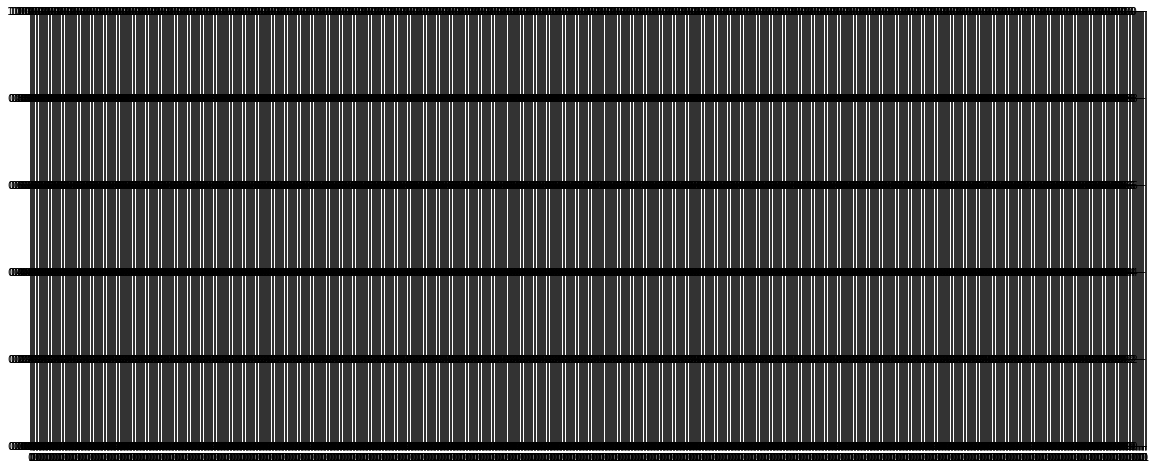

In [30]:
n_subplots = len(data_6.index.levels[0].astype(int))
fig, axes = plt.subplots(nrows=1, ncols=n_subplots, figsize=(20, 8))  # width, height

In [31]:
graph = dict(zip(data_6.index.levels[0].astype(int), axes))

In [32]:
graph

{118: <matplotlib.axes._subplots.AxesSubplot at 0x2db265fe1c8>,
 164: <matplotlib.axes._subplots.AxesSubplot at 0x2db8c403c88>,
 221: <matplotlib.axes._subplots.AxesSubplot at 0x2dbf99d0a48>,
 340: <matplotlib.axes._subplots.AxesSubplot at 0x2dbf1036608>,
 1683: <matplotlib.axes._subplots.AxesSubplot at 0x2dbe9c26488>,
 1684: <matplotlib.axes._subplots.AxesSubplot at 0x2dbe1809208>,
 1700: <matplotlib.axes._subplots.AxesSubplot at 0x2dbd99604c8>,
 1702: <matplotlib.axes._subplots.AxesSubplot at 0x2dbd0a5dac8>,
 1705: <matplotlib.axes._subplots.AxesSubplot at 0x2dbc9ba16c8>,
 1707: <matplotlib.axes._subplots.AxesSubplot at 0x2dbc18319c8>,
 1708: <matplotlib.axes._subplots.AxesSubplot at 0x2dbb702b148>,
 2019: <matplotlib.axes._subplots.AxesSubplot at 0x2dbaf1778c8>,
 2026: <matplotlib.axes._subplots.AxesSubplot at 0x2dba7dd4d48>,
 2076: <matplotlib.axes._subplots.AxesSubplot at 0x2db868d5888>,
 3390: <matplotlib.axes._subplots.AxesSubplot at 0x2db7cab83c8>,
 3578: <matplotlib.axes._subp

No handles with labels found to put in legend.


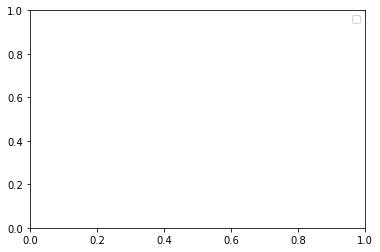

In [33]:
plots=list(map(lambda x: data_6.xs(x).plot(kind='bar', ax=graph[x], legend=False).set_xlabel(x, weight='bold'), graph))
#ax.tick_params(axis='both', which='both', length=0)
fig.subplots_adjust(wspace=0)
plt.legend()
plt.show()

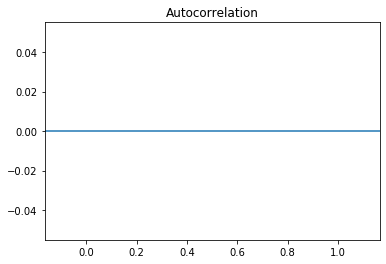

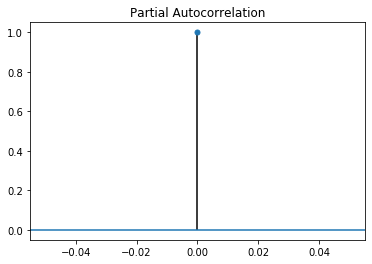

In [34]:
plot_acf(data_6.AMT)
plot_pacf(data_6.AMT)
plt.show()

In [35]:
data_6

AMT       AMT_P   CNT_P     AMT_C  CNT_C  \
BLCK_CD TA_YM                                                         
118     2017-01 0   10334490.0  10042630.0  1853.0  291860.0   14.0   
                1    1287000.0   1287000.0    33.0       0.0    0.0   
                2    1983000.0   1983000.0     9.0       0.0    0.0   
                3    1990400.0   1990400.0    82.0       0.0    0.0   
                4    2383000.0   2213200.0   209.0  169800.0    9.0   
...                        ...         ...     ...       ...    ...   
33564   2017-01 29    470000.0    470000.0     5.0       0.0    0.0   
                30   1817500.0   1817500.0     6.0       0.0    0.0   
                31   4579600.0   4033800.0   417.0  545800.0   31.0   
                32    561000.0    462000.0    11.0   99000.0    2.0   
                33   4428500.0   4268000.0    71.0  160500.0    3.0   

                        AMT_M   CNT_M      AMT_F  CNT_F    AMT_10  ...  \
BLCK_CD TA_YM                                                      ...   
118     2017-01 0   6989000.0  1287.0  3053630.0  566.0  212430.0  ...   
                1    758000.0    20.0   529000.0   13.0       0.0  ...   
                2   1983000.0     9.0        0.0    0.0       0.0  ...   
                3   1682100.0    69.0   308300.0   13.0       0.0  ...   
                4    966100.0    88.0  1247100.0  121.0    3800.0  ...   
...                       ...     ...        ...    ...       ...  ...   
33564   2017-01 29        0.0     0.0   470000.0    5.0       0.0  ...   
                30        0.0     0.0  1817500.0    6.0       0.0  ...   
                31  1686400.0   164.0  2347400.0  253.0  103100.0  ...   
                32   224000.0     5.0   238000.0    6.0       0.0  ...   
                33  2419300.0    40.0  1848700.0   31.0  139300.0  ...   

                    XCNTS_MIN_VALUE  YDNTS_MIN_VALUE  XCNTS_MAX_VALUE  \
BLCK_CD TA_YM                                                           
118     2017-01 0               NaN              NaN              NaN   
                1               NaN              NaN              NaN   
                2               NaN              NaN              NaN   
                3               NaN              NaN              NaN   
                4               NaN              NaN              NaN   
...                             ...              ...              ...   
33564   2017-01 29              NaN              NaN              NaN   
                30              NaN              NaN              NaN   
                31              NaN              NaN              NaN   
                32              NaN              NaN              NaN   
                33              NaN              NaN              NaN   

                    YDNTS_MAX_VALUE  XCNTS_VALUE  YDNTS_VALUE  COAR_CD  \
BLCK_CD TA_YM                                                            
118     2017-01 0               NaN          NaN          NaN      NaN   
                1               NaN          NaN          NaN      NaN   
                2               NaN          NaN          NaN      NaN   
                3               NaN          NaN          NaN      NaN   
                4               NaN          NaN          NaN      NaN   
...                             ...          ...          ...      ...   
33564   2017-01 29              NaN          NaN          NaN      NaN   
                30              NaN          NaN          NaN      NaN   
                31              NaN          NaN          NaN      NaN   
                32              NaN          NaN          NaN      NaN   
                33              NaN          NaN          NaN      NaN   

                    BLCK_REPRSNT_NMFPC  SIGNGU_CD  RELM_AR  
BLCK_CD TA_YM                                               
118     2017-01 0                  NaN        NaN      NaN  
                1                  NaN      

In [36]:
data_6.columns

Index(['AMT', 'AMT_P', 'CNT_P', 'AMT_C', 'CNT_C', 'AMT_M', 'CNT_M', 'AMT_F',
       'CNT_F', 'AMT_10', 'CNT_10', 'AMT_20', 'CNT_20', 'AMT_30', 'CNT_30',
       'AMT_40', 'CNT_40', 'AMT_50', 'CNT_50', 'AMT_60', 'CNT_60', 'AMT_T06',
       'CNT_T06', 'AMT_T11', 'CNT_T11', 'AMT_T14', 'CNT_T14', 'AMT_T17',
       'CNT_T17', 'AMT_T21', 'CNT_T21', 'AMT_T24', 'CNT_T24', 'AMT_SUN',
       'CNT_SUN', 'AMT_MON', 'CNT_MON', 'AMT_TUE', 'CNT_TUE', 'AMT_WED',
       'CNT_WED', 'AMT_THU', 'CNT_THU', 'AMT_FRI', 'CNT_FRI', 'AMT_SAT',
       'CNT_SAT', 'RCNT_10', 'RCNT_20', 'RCNT_30', 'RCNT_40', 'RCNT_50',
       'RCNT_60', 'MCT_SALES', 'NEW_MCT', 'P1_M6', 'P1_1Y', 'P1_2Y', 'P1_3Y',
       'P1_4Y', 'P1_5Y', 'P1_6Y', 'TOT_FLPOP_CO', 'MON_FLPOP_CO',
       'TUES_FLPOP_CO', 'WED_FLPOP_CO', 'THUR_FLPOP_CO', 'FRI_FLPOP_CO',
       'SAT_FLPOP_CO', 'SUN_FLPOP_CO', '0', 'CNVRSN_RNTCHRG',
       'XCNTS_MIN_VALUE', 'YDNTS_MIN_VALUE', 'XCNTS_MAX_VALUE',
       'YDNTS_MAX_VALUE', 'XCNTS_VALUE', 'YDNTS_VALUE', 'COAR

In [37]:
data_6=data_6[['AMT','TOT_FLPOP_CO','CNVRSN_RNTCHRG']] #안쓰는 칼럼 제외

In [38]:
data_6

AMT  TOT_FLPOP_CO  CNVRSN_RNTCHRG
BLCK_CD TA_YM                                               
118     2017-01 0   10334490.0       23859.6             NaN
                1    1287000.0       23859.6             NaN
                2    1983000.0       23859.6             NaN
                3    1990400.0       23859.6             NaN
                4    2383000.0       23859.6             NaN
...                        ...           ...             ...
33564   2017-01 29    470000.0       19600.0             NaN
                30   1817500.0       19600.0             NaN
                31   4579600.0       19600.0             NaN
                32    561000.0       19600.0             NaN
                33   4428500.0       19600.0             NaN

[38152 rows x 3 columns]

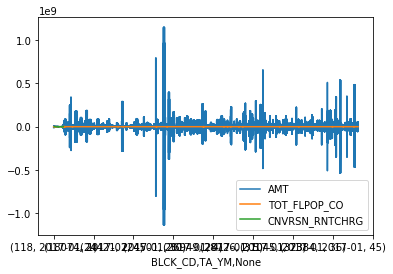

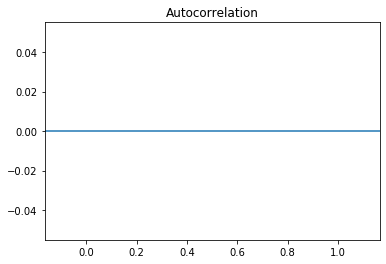

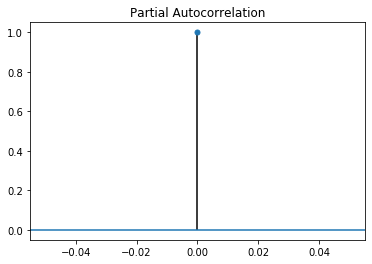

In [39]:
diff_1=data_6.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1.AMT)
plot_pacf(diff_1.AMT)
plt.show()

In [40]:
data_6.fillna(0, inplace=True)

C:\Users\bigdata12\Anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [41]:
data_6

AMT  TOT_FLPOP_CO  CNVRSN_RNTCHRG
BLCK_CD TA_YM                                               
118     2017-01 0   10334490.0       23859.6             0.0
                1    1287000.0       23859.6             0.0
                2    1983000.0       23859.6             0.0
                3    1990400.0       23859.6             0.0
                4    2383000.0       23859.6             0.0
...                        ...           ...             ...
33564   2017-01 29    470000.0       19600.0             0.0
                30   1817500.0       19600.0             0.0
                31   4579600.0       19600.0             0.0
                32    561000.0       19600.0             0.0
                33   4428500.0       19600.0             0.0

[38152 rows x 3 columns]

In [42]:
model = ARIMA(data_6.AMT, order=(0,1,1)) #p,d, q값 설정할것

C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [43]:
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.AMT   No. Observations:                38151
Model:                 ARIMA(0, 1, 1)   Log Likelihood             -713594.668
Method:                       css-mle   S.D. of innovations       32136687.964
Date:                Thu, 17 Sep 2020   AIC                        1427195.336
Time:                        13:16:23   BIC                        1427220.984
Sample:                             1   HQIC                       1427203.473
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -154.8056   6289.675     -0.025      0.980   -1.25e+04    1.22e+04
ma.L1.D.AMT    -0.9618      0.001   -652.405      0.000      -0.965      -0.959
                                    Roots       

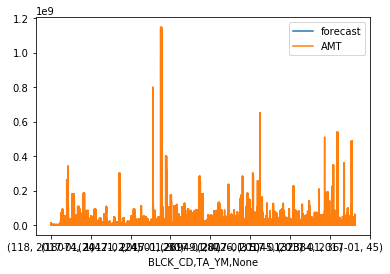

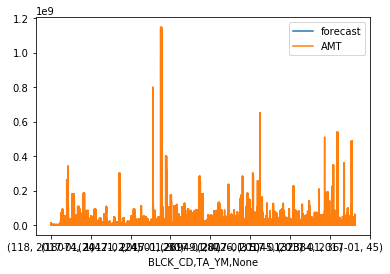

In [44]:
model_fit.plot_predict()
#fore=model_fit.forecast(steps=1)
#print(fore)

In [45]:
#시계열분석2
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [46]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [47]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [48]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_6['AMT'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1432302.5883343916


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1431267.9095079305


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1452573.3051017453


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428796.980121021


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1431153.826947627


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1428123.5422257693


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1441200.6233190848


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1428679.5432655406


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1431678.6305926028


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1430862.4184599216


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1452478.9956134933


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1434077.602034795


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1430846.7636394517


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1428127.796308195


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1442620.196761054


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1434071.8677810563


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1453045.6065309895


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1452554.1353534446


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1480413.440189967


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1456607.1066865996


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1452587.8835575487


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1452308.4948278554


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1467227.2426576277


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1454186.4776451907


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1427956.6940813567


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1427511.2588905438


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1454090.7033943057


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1439545.0091584194


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1427584.6395949947


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1427513.6498806654


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1446489.2149509138


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1439535.3867025895


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1431571.3425376099


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1430815.058895622


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1452518.6315963208


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1434109.1491476938


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1430740.3752538054


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1428132.0690227866


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1442583.0910468893


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1434104.220278724


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1427236.799027241


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1426790.8988880934


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1451681.7711740881


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1433242.462495756


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1426827.5080951983


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1426577.76851244


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1442331.5957939518


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1433233.5572607329


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1442015.2627035154


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1441548.8396693864


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1468995.7633582081


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1448986.2417908076


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1441549.1596074174


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1441550.7331062497


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1458641.8944956209


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1448961.7502258345


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1427939.091076991


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1427493.102412202


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1454381.0851047954


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1439459.0042154575


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1427529.8806904429


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1427495.7485571466


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1446397.5809261168


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1439449.5397300278


In [49]:
mod = sm.tsa.statespace.SARIMAX(data_6['AMT'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12), #위의 블럭에서 최저 AIC값인 것 찾기
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0084      0.003      2.839      0.005       0.003       0.014
ma.L1         -0.9992      0.000  -2642.460      0.000      -1.000      -0.998
ar.S.L12      -0.5003      0.001   -556.020      0.000      -0.502      -0.499
sigma2      2.708e+15        nan        nan        nan         nan         nan


C:\Users\bigdata12\Anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


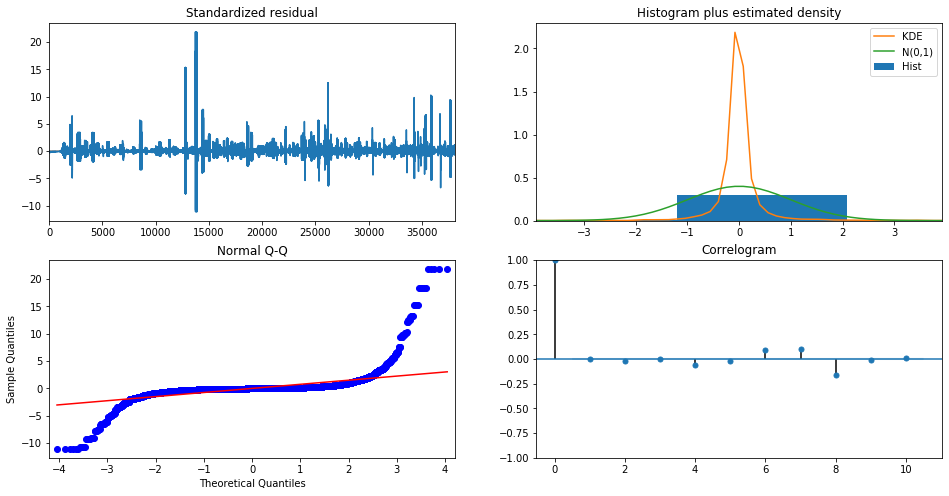

In [50]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

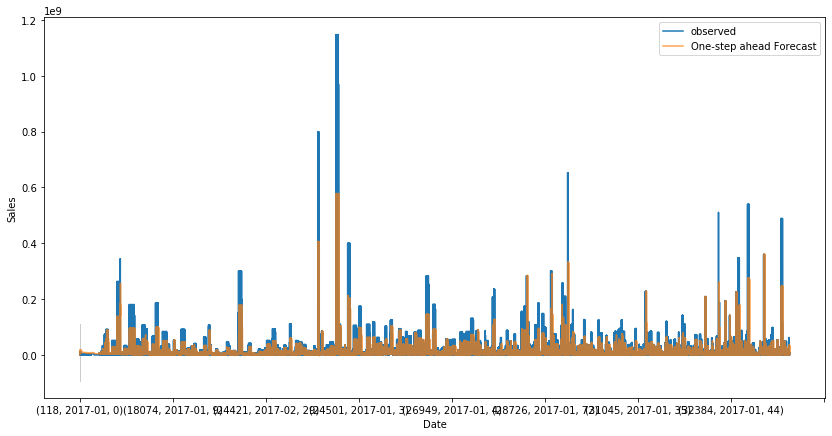

In [51]:
pred = results.get_prediction(start = 0, dynamic=False)
pred_ci = pred.conf_int() #추정된 계수의 신뢰구간 계산
ax = data_6['AMT'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
pred_ci=pred_ci.astype(np.float64)
ax.fill_between("year", pred_ci.iloc[0], pred_ci.iloc[1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [53]:
y_forecasted = pred.predicted_mean
y_truth = data_6['AMT']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1526728565959626.0
The Root Mean Squared Error of our forecasts is 39073374.13
